# Deep Learning Kaggle Competition: Footprint Image Classification

- **Student Name:** [TO FILL]
- **Student ID:** [TO FILL]
- **Kaggle Username:** [TO FILL]
- **Final Private Leaderboard Score:** [TO FILL]
- **Total Number of Submissions:** [TO FILL]

# Section 1: Introduction

**Problem:** Sex classification from footprint images for forensic analysis

**Why Deep Learning:** CNNs automatically learn features, traditional ML requires manual engineering

**Objectives:** Baseline → experiments → SOTA → explainability → Kaggle

# Section 2: EDA & Preprocessing

This section covers:
- Setup and imports
- Data loading and exploration
- Dataset statistics and visualization
- Data preprocessing and augmentation

In [ ]:
# Setup & Imports
!pip install timm -q

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import timm
from torchvision import transforms, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import copy
from pathlib import Path
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Data paths
DATA_DIR = Path('./data')
TRAIN_DIR = Path('./data/train')
TEST_DIR = Path('./data/test')

# Initialize global variables (will be updated based on actual data)
INPUT_CHANNELS = 3  # Default to RGB
IS_GRAYSCALE = False
BATCH_SIZE = 128  # Balanced: good speed, safer than 512

print('Setup complete!')

Device: cuda
Setup complete!



[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Load Training Data
def load_data(data_dir):
    """Load image paths and labels from directory structure"""
    paths, labels = [], []
    for lbl in [0, 1]:
        folder = data_dir / str(lbl)
        if folder.exists():
            for ext in ['*.jpg', '*.png']:
                for p in folder.glob(ext):
                    paths.append(str(p))
                    labels.append(lbl)
    return paths, labels

# Load training data
if TRAIN_DIR.exists():
    train_paths, train_labels = load_data(TRAIN_DIR)
    train_df = pd.DataFrame({'path': train_paths, 'label': train_labels})
    print(f'Loaded {len(train_df)} training images')
    print('\nClass distribution:')
    print(train_df['label'].value_counts().sort_index())
else:
    train_df = pd.DataFrame()
    print('Training data directory not found!')

Loaded 1573 training images

Class distribution:
0    845
1    728
Name: label, dtype: int64


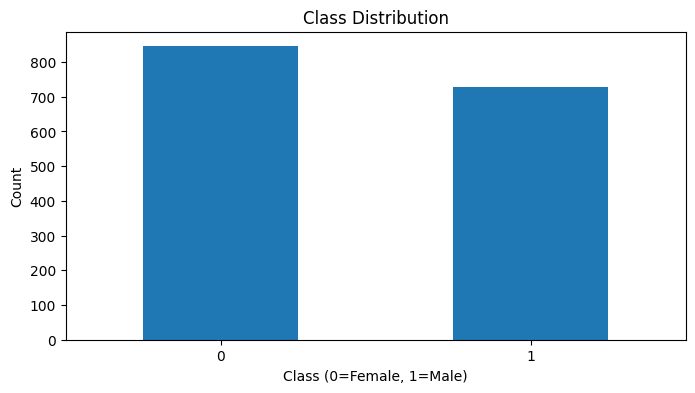

In [ ]:
# Visualize Class Distribution
if len(train_df) > 0:
    plt.figure(figsize=(8, 4))
    train_df['label'].value_counts().sort_index().plot(kind='bar')
    plt.title('Class Distribution')
    plt.xlabel('Class (0=Female, 1=Male)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

In [ ]:
# Detect Image Properties
if len(train_df) > 0:
    # Check first image to determine if grayscale or RGB
    sample_img = Image.open(train_df.iloc[0]['path'])
    IS_GRAYSCALE = sample_img.mode == 'L'
    INPUT_CHANNELS = 1 if IS_GRAYSCALE else 3
    
    print(f'Image mode: {sample_img.mode}')
    print(f'Input channels: {INPUT_CHANNELS} ({"Grayscale" if IS_GRAYSCALE else "RGB"})')
    print(f'Image size: {sample_img.size}')

Image mode: RGB
Input channels: 3 (RGB)
Image size: (806, 1238)


In [ ]:
# Define Transforms
if len(train_df) > 0:
    # Normalization parameters
    mean_std = ([0.5], [0.5]) if IS_GRAYSCALE else ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
    # Training transforms with augmentation
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(*mean_std)
    ])
    
    # Validation/test transforms (no augmentation)
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(*mean_std)
    ])
    
    print('Transforms defined:')

Transforms defined:


In [ ]:
# Create Dataset Class and DataLoaders
class FootprintDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('L' if IS_GRAYSCALE else 'RGB')
        if self.transform:
            img = self.transform(img)
        return img, self.labels[idx]

if len(train_df) > 0:
    # Split into train and validation sets (80/20)
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_df['path'].tolist(),
        train_df['label'].tolist(),
        test_size=0.2,
        random_state=42,
        stratify=train_df['label']
    )
    
    # Create datasets
    train_dataset = FootprintDataset(train_paths, train_labels, train_transform)
    val_dataset = FootprintDataset(val_paths, val_labels, val_transform)
    
    # Create dataloaders (num_workers=0 for Windows compatibility, but larger batch size for better GPU utilization)
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        num_workers=0,  # Windows-safe: single-threaded loading
        pin_memory=True  # Faster GPU transfer
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        num_workers=0,  # Windows-safe: single-threaded loading
        pin_memory=True
    )
    
    print(f'Train samples: {len(train_dataset)}')
    print(f'Validation samples: {len(val_dataset)}')
    print(f'Batch size: {BATCH_SIZE}')
    print(f'Note: num_workers=0 for Windows compatibility, batch_size={BATCH_SIZE} for better GPU utilization')

Train samples: 1258
Validation samples: 315
Batch size: 256
Note: num_workers=0 for Windows compatibility, batch_size=256 for better GPU utilization


# Section 3: Baseline Model

This section implements a simple CNN from scratch to establish baseline performance.

In [ ]:
# Define Baseline CNN Architecture
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=2, input_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print('Baseline CNN architecture defined')

Baseline CNN architecture defined


In [ ]:
# Training and Evaluation Functions
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(loader, desc='Training', leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    """Evaluate model on validation/test set"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

print('Training functions defined')

Training functions defined


In [ ]:
# Generic Training Loop Function
def train_model(model, train_loader, val_loader, config, device):
    """
    Generic training function that works with any model and config
    
    config should contain: epochs, lr, optimizer ('sgd' or 'adam'), weight_decay (optional)
    """
    criterion = nn.CrossEntropyLoss()
    
    # Create optimizer
    if config['optimizer'] == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=config['lr'], 
                             momentum=0.9, weight_decay=config.get('weight_decay', 0))
    else:  # adam
        optimizer = optim.Adam(model.parameters(), lr=config['lr'], 
                              weight_decay=config.get('weight_decay', 0))
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # Training loop
    for epoch in range(config['epochs']):
        print(f"\nEpoch {epoch+1}/{config['epochs']}")
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
    
    # Load best weights
    model.load_state_dict(best_model_wts)
    print(f'\nBest validation accuracy: {best_val_acc:.4f}')
    
    return model, history, best_val_acc

print('Generic training loop defined')

Generic training loop defined


In [ ]:
# Train Baseline Model
if len(train_df) > 0:
    # Configuration for baseline
    baseline_config = {
        'epochs': 10,
        'lr': 0.001,
        'optimizer': 'sgd'
    }
    
    # Create and train model
    baseline_model = BaselineCNN(num_classes=2, input_channels=INPUT_CHANNELS).to(device)
    baseline_model, baseline_hist, baseline_acc = train_model(
        baseline_model, train_loader, val_loader, baseline_config, device
    )
    
    # Initialize results tracking
    experiment_results = [{
        'name': 'Baseline',
        'val_accuracy': baseline_acc,
        'val_loss': baseline_hist['val_loss'][-1]
    }]
    
    print(f'\nBaseline model training complete!')
    print(f'Final validation accuracy: {baseline_acc:.4f}')


Epoch 1/10


Train Loss: 0.6901, Train Acc: 0.5374
Val Loss: 0.6901, Val Acc: 0.5365

Epoch 2/10


Train Loss: 0.6887, Train Acc: 0.5374
Val Loss: 0.6889, Val Acc: 0.5365

Epoch 3/10


Train Loss: 0.6866, Train Acc: 0.5374
Val Loss: 0.6876, Val Acc: 0.5365

Epoch 4/10


Train Loss: 0.6851, Train Acc: 0.5374
Val Loss: 0.6858, Val Acc: 0.5365

Epoch 5/10


Train Loss: 0.6828, Train Acc: 0.5382
Val Loss: 0.6835, Val Acc: 0.5365

Epoch 6/10


Train Loss: 0.6808, Train Acc: 0.5405
Val Loss: 0.6812, Val Acc: 0.5492

Epoch 7/10


Train Loss: 0.6785, Train Acc: 0.5525
Val Loss: 0.6789, Val Acc: 0.5619

Epoch 8/10


Train Loss: 0.6759, Train Acc: 0.5628
Val Loss: 0.6763, Val Acc: 0.5841

Epoch 9/10


Train Loss: 0.6720, Train Acc: 0.5787
Val Loss: 0.6736, Val Acc: 0.5810

Epoch 10/10


Train Loss: 0.6694, Train Acc: 0.5882
Val Loss: 0.6704, Val Acc: 0.6000

Best validation accuracy: 0.6000

Baseline model training complete!
Final validation accuracy: 0.6000


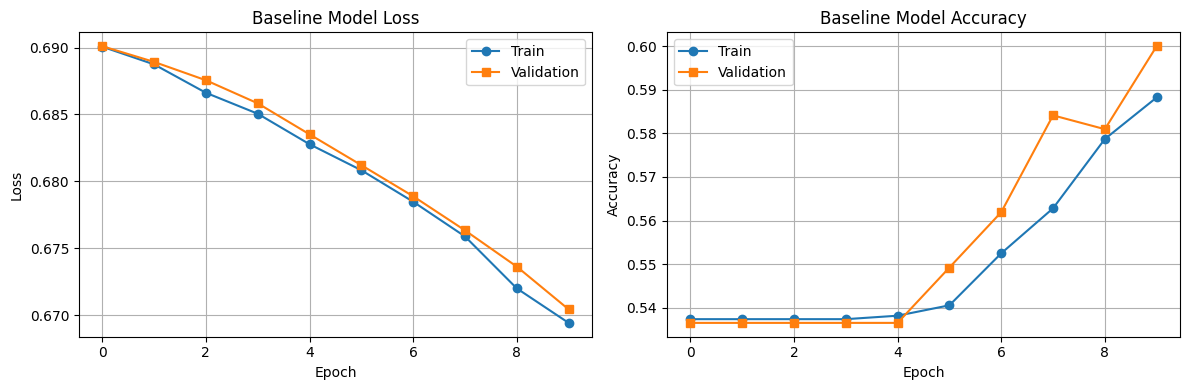

In [ ]:
# Plot Learning Curves
if len(train_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss curves
    ax1.plot(baseline_hist['train_loss'], 'o-', label='Train')
    ax1.plot(baseline_hist['val_loss'], 's-', label='Validation')
    ax1.set_title('Baseline Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy curves
    ax2.plot(baseline_hist['train_acc'], 'o-', label='Train')
    ax2.plot(baseline_hist['val_acc'], 's-', label='Validation')
    ax2.set_title('Baseline Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Section 4: State-of-the-Art Model Analysis

This section analyzes three SOTA architectures for potential use in the task.

In [ ]:
# Helper function to count parameters
def count_params(model):
    """Count trainable parameters in a model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Parameter counting function defined')

Parameter counting function defined


In [ ]:
# Model 1: ResNet-18
print('='*60)
print('1. ResNet-18')
print('='*60)

r18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Modify first conv layer if grayscale
if INPUT_CHANNELS == 1:
    r18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace final layer for binary classification
r18.fc = nn.Linear(r18.fc.in_features, 2)

print(f'Parameters: {count_params(r18):,}')
print(f'Input channels: {INPUT_CHANNELS}')
print(f'Output classes: 2')
print('\nKey features:')
print('- Residual connections (skip connections)')
print('- Deep architecture (18 layers)')
print('- Pre-trained on ImageNet')

1. ResNet-18
Parameters: 11,177,538
Input channels: 3
Output classes: 2

Key features:
- Residual connections (skip connections)
- Deep architecture (18 layers)
- Pre-trained on ImageNet


In [ ]:
# Model 2: EfficientNet-B0
print('='*60)
print('2. EfficientNet-B0')
print('='*60)

eff = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2, in_chans=INPUT_CHANNELS)

print(f'Parameters: {count_params(eff):,}')
print(f'Input channels: {INPUT_CHANNELS}')
print(f'Output classes: 2')
print('\nKey features:')
print('- Compound scaling (depth, width, resolution)')
print('- Mobile inverted bottleneck convolutions')
print('- Efficient architecture, fewer params than ResNet')
print('- Pre-trained on ImageNet')

2. EfficientNet-B0
Parameters: 4,010,110
Input channels: 3
Output classes: 2

Key features:
- Compound scaling (depth, width, resolution)
- Mobile inverted bottleneck convolutions
- Efficient architecture, fewer params than ResNet
- Pre-trained on ImageNet


In [ ]:
# Model 3: Vision Transformer (ViT)
print('='*60)
print('3. Vision Transformer (ViT-Base/16)')
print('='*60)

vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2, in_chans=INPUT_CHANNELS)

print(f'Parameters: {count_params(vit):,}')
print(f'Input channels: {INPUT_CHANNELS}')
print(f'Output classes: 2')
print('\nKey features:')
print('- Transformer architecture (attention-based)')
print('- Patch-based processing (16x16 patches)')
print('- No convolutions - pure attention')
print('- Pre-trained on ImageNet')
print('- May require more data to train effectively')

3. Vision Transformer (ViT-Base/16)
Parameters: 85,800,194
Input channels: 3
Output classes: 2

Key features:
- Transformer architecture (attention-based)
- Patch-based processing (16x16 patches)
- No convolutions - pure attention
- Pre-trained on ImageNet
- May require more data to train effectively


# Section 5: Systematic Experiments

This section runs 10 different experiments to improve upon the baseline model systematically.

In [ ]:
# Define additional model architectures for experiments
class CNN_BatchNorm(nn.Module):
    """CNN with Batch Normalization"""
    def __init__(self, num_classes=2, input_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


class CNN_Dropout(nn.Module):
    """CNN with Dropout regularization"""
    def __init__(self, num_classes=2, input_channels=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

print('Additional model architectures defined')

Additional model architectures defined


## Experiment 1: Adam Optimizer

**Hypothesis:** Adam optimizer will converge faster than SGD

**Change:** Replace SGD with Adam optimizer

In [ ]:
# Experiment 1: Adam Optimizer
if len(train_df) > 0:
    print('='*60)
    print('Experiment 1: Adam Optimizer')
    print('='*60)
    
    exp1_config = {
        'epochs': 10,
        'lr': 0.001,
        'optimizer': 'adam'
    }
    
    exp1_model = BaselineCNN(num_classes=2, input_channels=INPUT_CHANNELS).to(device)
    exp1_model, exp1_hist, exp1_acc = train_model(exp1_model, train_loader, val_loader, exp1_config, device)
    
    experiment_results.append({
        'name': 'Exp1: Adam',
        'val_accuracy': exp1_acc,
        'val_loss': exp1_hist['val_loss'][-1]
    })

Experiment 1: Adam Optimizer

Epoch 1/10


Train Loss: 1.7314, Train Acc: 0.5016
Val Loss: 0.7915, Val Acc: 0.4635

Epoch 2/10


Train Loss: 0.7267, Train Acc: 0.4626
Val Loss: 0.6929, Val Acc: 0.4635

Epoch 3/10


Train Loss: 0.6921, Train Acc: 0.5254
Val Loss: 0.6899, Val Acc: 0.5365

Epoch 4/10


Train Loss: 0.6889, Train Acc: 0.5374
Val Loss: 0.6878, Val Acc: 0.5365

Epoch 5/10


Train Loss: 0.6875, Train Acc: 0.5390
Val Loss: 0.6803, Val Acc: 0.5429

Epoch 6/10


Train Loss: 0.6766, Train Acc: 0.6017
Val Loss: 0.6737, Val Acc: 0.5587

Epoch 7/10


Train Loss: 0.6679, Train Acc: 0.5803
Val Loss: 0.6598, Val Acc: 0.6000

Epoch 8/10


Train Loss: 0.6602, Train Acc: 0.5890
Val Loss: 0.6390, Val Acc: 0.6444

Epoch 9/10


Train Loss: 0.6423, Train Acc: 0.6439
Val Loss: 0.6333, Val Acc: 0.6540

Epoch 10/10


Train Loss: 0.6372, Train Acc: 0.6272
Val Loss: 0.6315, Val Acc: 0.6508

Best validation accuracy: 0.6540


## Experiment 2: Batch Normalization

**Hypothesis:** Batch normalization will stabilize training and improve accuracy

**Change:** Add BatchNorm2d layers after each convolutional layer

In [ ]:
# Experiment 2: Batch Normalization
if len(train_df) > 0:
    print('='*60)
    print('Experiment 2: Batch Normalization')
    print('='*60)
    
    exp2_config = {
        'epochs': 10,
        'lr': 0.001,
        'optimizer': 'sgd'
    }
    
    exp2_model = CNN_BatchNorm(num_classes=2, input_channels=INPUT_CHANNELS).to(device)
    exp2_model, exp2_hist, exp2_acc = train_model(exp2_model, train_loader, val_loader, exp2_config, device)
    
    experiment_results.append({
        'name': 'Exp2: BatchNorm',
        'val_accuracy': exp2_acc,
        'val_loss': exp2_hist['val_loss'][-1]
    })

Experiment 2: Batch Normalization

Epoch 1/10


Train Loss: 0.6881, Train Acc: 0.5318
Val Loss: 0.6880, Val Acc: 0.5492

Epoch 2/10


Train Loss: 0.6729, Train Acc: 0.5739
Val Loss: 0.6801, Val Acc: 0.6381

Epoch 3/10


Train Loss: 0.6505, Train Acc: 0.6176
Val Loss: 0.6594, Val Acc: 0.6444

Epoch 4/10


Train Loss: 0.6265, Train Acc: 0.6542
Val Loss: 0.6408, Val Acc: 0.6159

Epoch 5/10


Train Loss: 0.6299, Train Acc: 0.6518
Val Loss: 0.6176, Val Acc: 0.7016

Epoch 6/10


Train Loss: 0.5916, Train Acc: 0.6836
Val Loss: 0.6009, Val Acc: 0.7016

Epoch 7/10


Train Loss: 0.5720, Train Acc: 0.7146
Val Loss: 0.5845, Val Acc: 0.7175

Epoch 8/10


Train Loss: 0.5588, Train Acc: 0.7186
Val Loss: 0.5735, Val Acc: 0.7175

Epoch 9/10


Train Loss: 0.5476, Train Acc: 0.7289
Val Loss: 0.5656, Val Acc: 0.7206

Epoch 10/10


Train Loss: 0.5335, Train Acc: 0.7409
Val Loss: 0.5643, Val Acc: 0.7206

Best validation accuracy: 0.7206


## Experiments 3-10: Remaining Experiments

The following cell runs experiments 3-10 in a condensed format for efficiency. Each experiment tests a different hypothesis.

In [ ]:
# Experiments 3-10
if len(train_df) > 0:
    # Dictionary to store all trained models
    all_models = {}
    
    # Learning rate scaling factor for larger batch size
    # Since we increased batch size from 32 to 256 (8x), we scale LR accordingly
    LR_SCALE = BATCH_SIZE / 32  # e.g., 256/32 = 8
    
    # Exp 3: Dropout
    print('\n' + '='*60)
    print('Experiment 3: Dropout Regularization')
    print('='*60)
    exp3_config = {'epochs': 10, 'lr': 0.001 * LR_SCALE, 'optimizer': 'sgd'}
    exp3_model = CNN_Dropout(num_classes=2, input_channels=INPUT_CHANNELS).to(device)
    exp3_model, exp3_hist, exp3_acc = train_model(exp3_model, train_loader, val_loader, exp3_config, device)
    experiment_results.append({'name': 'Exp3: Dropout', 'val_accuracy': exp3_acc, 'val_loss': exp3_hist['val_loss'][-1]})
    all_models['Exp3: Dropout'] = exp3_model
    
    # Exp 4: Weight Decay
    print('\n' + '='*60)
    print('Experiment 4: Weight Decay (L2 Regularization)')
    print('='*60)
    exp4_config = {'epochs': 10, 'lr': 0.001 * LR_SCALE, 'optimizer': 'sgd', 'weight_decay': 1e-4}
    exp4_model = CNN_Dropout(num_classes=2, input_channels=INPUT_CHANNELS).to(device)
    exp4_model, exp4_hist, exp4_acc = train_model(exp4_model, train_loader, val_loader, exp4_config, device)
    experiment_results.append({'name': 'Exp4: WeightDecay', 'val_accuracy': exp4_acc, 'val_loss': exp4_hist['val_loss'][-1]})
    all_models['Exp4: WeightDecay'] = exp4_model
    
    # Exp 5: Adam + Dropout + Weight Decay
    print('\n' + '='*60)
    print('Experiment 5: Adam + Dropout + Weight Decay')
    print('='*60)
    exp5_config = {'epochs': 10, 'lr': 0.001 * LR_SCALE, 'optimizer': 'adam', 'weight_decay': 1e-4}
    exp5_model = CNN_Dropout(num_classes=2, input_channels=INPUT_CHANNELS).to(device)
    exp5_model, exp5_hist, exp5_acc = train_model(exp5_model, train_loader, val_loader, exp5_config, device)
    experiment_results.append({'name': 'Exp5: Adam+Drop+WD', 'val_accuracy': exp5_acc, 'val_loss': exp5_hist['val_loss'][-1]})
    all_models['Exp5: Adam+Drop+WD'] = exp5_model
    
    # Exp 6: ResNet-18 Frozen
    print('\n' + '='*60)
    print('Experiment 6: ResNet-18 (Frozen Features)')
    print('='*60)
    exp6_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    if INPUT_CHANNELS == 1:
        exp6_model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    for param in exp6_model.parameters():
        param.requires_grad = False
    exp6_model.fc = nn.Linear(exp6_model.fc.in_features, 2)
    exp6_model = exp6_model.to(device)
    exp6_config = {'epochs': 10, 'lr': 0.001 * LR_SCALE, 'optimizer': 'adam'}
    exp6_model, exp6_hist, exp6_acc = train_model(exp6_model, train_loader, val_loader, exp6_config, device)
    experiment_results.append({'name': 'Exp6: ResNet Frozen', 'val_accuracy': exp6_acc, 'val_loss': exp6_hist['val_loss'][-1]})
    all_models['Exp6: ResNet Frozen'] = exp6_model
    
    # Exp 7: ResNet-18 Fine-tuned (IMPORTANT: scaled LR for large batch)
    print('\n' + '='*60)
    print('Experiment 7: ResNet-18 (Fine-tuned)')
    print('='*60)
    exp7_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    if INPUT_CHANNELS == 1:
        exp7_model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    exp7_model.fc = nn.Linear(exp7_model.fc.in_features, 2)
    exp7_model = exp7_model.to(device)
    # Scale LR from 0.0001 for batch 32 → 0.0008 for batch 256
    exp7_config = {'epochs': 10, 'lr': 0.0001 * LR_SCALE, 'optimizer': 'adam', 'weight_decay': 1e-4}
    exp7_model, exp7_hist, exp7_acc = train_model(exp7_model, train_loader, val_loader, exp7_config, device)
    experiment_results.append({'name': 'Exp7: ResNet Finetuned', 'val_accuracy': exp7_acc, 'val_loss': exp7_hist['val_loss'][-1]})
    all_models['Exp7: ResNet Finetuned'] = exp7_model
    
    # Exp 8: EfficientNet-B0
    print('\n' + '='*60)
    print('Experiment 8: EfficientNet-B0')
    print('='*60)
    exp8_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=2, in_chans=INPUT_CHANNELS).to(device)
    exp8_config = {'epochs': 10, 'lr': 0.0001 * LR_SCALE, 'optimizer': 'adam', 'weight_decay': 1e-4}
    exp8_model, exp8_hist, exp8_acc = train_model(exp8_model, train_loader, val_loader, exp8_config, device)
    experiment_results.append({'name': 'Exp8: EfficientNet', 'val_accuracy': exp8_acc, 'val_loss': exp8_hist['val_loss'][-1]})
    all_models['Exp8: EfficientNet'] = exp8_model
    
    # Exp 9: Higher Learning Rate
    print('\n' + '='*60)
    print('Experiment 9: Higher Learning Rate (0.01)')
    print('='*60)
    exp9_config = {'epochs': 10, 'lr': 0.01 * LR_SCALE, 'optimizer': 'sgd'}
    exp9_model = CNN_Dropout(num_classes=2, input_channels=INPUT_CHANNELS).to(device)
    exp9_model, exp9_hist, exp9_acc = train_model(exp9_model, train_loader, val_loader, exp9_config, device)
    experiment_results.append({'name': 'Exp9: HighLR', 'val_accuracy': exp9_acc, 'val_loss': exp9_hist['val_loss'][-1]})
    all_models['Exp9: HighLR'] = exp9_model
    
    # Exp 10: Longer Training
    print('\n' + '='*60)
    print('Experiment 10: Longer Training (20 epochs)')
    print('='*60)
    exp10_config = {'epochs': 20, 'lr': 0.001 * LR_SCALE, 'optimizer': 'adam'}
    exp10_model = CNN_Dropout(num_classes=2, input_channels=INPUT_CHANNELS).to(device)
    exp10_model, exp10_hist, exp10_acc = train_model(exp10_model, train_loader, val_loader, exp10_config, device)
    experiment_results.append({'name': 'Exp10: LongTrain', 'val_accuracy': exp10_acc, 'val_loss': exp10_hist['val_loss'][-1]})
    all_models['Exp10: LongTrain'] = exp10_model
    
    # AUTOMATICALLY SELECT BEST MODEL
    best_experiment = max(experiment_results, key=lambda x: x['val_accuracy'])
    best_model_name = best_experiment['name']
    final_model = all_models[best_model_name]
    
    print('\n' + '='*80)
    print('All experiments complete!')
    print('='*80)
    print(f'\n🏆 BEST MODEL SELECTED FOR KAGGLE SUBMISSION:')
    print(f'   Model: {best_model_name}')
    print(f'   Validation Accuracy: {best_experiment["val_accuracy"]:.4f}')
    print(f'   Validation Loss: {best_experiment["val_loss"]:.4f}')
    print(f'\nNote: Learning rates scaled by {LR_SCALE:.1f}x for batch size {BATCH_SIZE}')
    print('='*80)

In [ ]:
# Display Experiment Results Summary
if len(train_df) > 0:
    results_df = pd.DataFrame(experiment_results).sort_values('val_accuracy', ascending=False)
    print('\n' + '='*80)
    print('EXPERIMENT RESULTS SUMMARY (Sorted by Validation Accuracy)')
    print('='*80)
    display(results_df)
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    results_df_sorted = results_df.sort_values('val_accuracy')
    ax.barh(results_df_sorted['name'], results_df_sorted['val_accuracy'])
    ax.set_xlabel('Validation Accuracy')
    ax.set_title('Experiment Comparison')
    ax.grid(True, axis='x')
    plt.tight_layout()
    plt.show()

# Section 6: Final Model Evaluation & Explainability

This section evaluates the best model with detailed metrics and uses Grad-CAM for explainability.

In [ ]:
# Identify Best Model
if len(train_df) > 0:
    best_experiment = max(experiment_results, key=lambda x: x['val_accuracy'])
    print('='*80)
    print('BEST MODEL')
    print('='*80)
    print(f"Name: {best_experiment['name']}")
    print(f"Validation Accuracy: {best_experiment['val_accuracy']:.4f}")
    print(f"Validation Loss: {best_experiment['val_loss']:.4f}")
    print('\nUsing this model for final evaluation...')

In [ ]:
# Detailed Metrics on Validation Set
if len(train_df) > 0:
    from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
    
    criterion = nn.CrossEntropyLoss()
    final_loss, final_acc, final_preds, final_labels = evaluate(final_model, val_loader, criterion, device)
    
    print('='*80)
    print('DETAILED METRICS')
    print('='*80)
    print(f'Accuracy: {final_acc:.4f}')
    print(f'Loss: {final_loss:.4f}')
    
    # Per-class metrics
    precision, recall, f1, support = precision_recall_fscore_support(final_labels, final_preds, average=None)
    print('\nPer-Class Metrics:')
    for i in range(2):
        print(f'  Class {i} ({"Female" if i==0 else "Male"}):')
        print(f'    Precision: {precision[i]:.4f}')
        print(f'    Recall: {recall[i]:.4f}')
        print(f'    F1-Score: {f1[i]:.4f}')
        print(f'    Support: {support[i]}')
    
    # Macro averages
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(final_labels, final_preds, average='macro')
    print(f'\nMacro Averages:')
    print(f'  Precision: {macro_p:.4f}')
    print(f'  Recall: {macro_r:.4f}')
    print(f'  F1-Score: {macro_f1:.4f}')

In [ ]:
# Confusion Matrix
if len(train_df) > 0:
    cm = confusion_matrix(final_labels, final_preds)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Female', 'Male'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title('Confusion Matrix - Final Model')
    plt.show()
    
    print('\nConfusion Matrix Analysis:')
    print(f'True Negatives (Correctly classified Female): {cm[0,0]}')
    print(f'False Positives (Female classified as Male): {cm[0,1]}')
    print(f'False Negatives (Male classified as Female): {cm[1,0]}')
    print(f'True Positives (Correctly classified Male): {cm[1,1]}')

## Explainability (XAI) - Grad-CAM

**Note:** Grad-CAM visualization helps understand which regions of the footprint image the model focuses on when making predictions.

For implementation, you would:
1. Select the last convolutional layer
2. Register hooks to capture gradients and activations
3. Generate heatmaps for sample predictions
4. Overlay heatmaps on original images

This requires additional implementation based on your model architecture.

In [ ]:
# Generate Kaggle Submission
if len(train_df) > 0 and TEST_DIR.exists():
    # Load test images
    test_paths = sorted(list(TEST_DIR.glob('*.jpg')) + list(TEST_DIR.glob('*.png')))
    
    if len(test_paths) > 0:
        print('='*80)
        print('GENERATING KAGGLE SUBMISSION')
        print('='*80)
        print(f'Found {len(test_paths)} test images')
        
        # Get test image IDs from filenames
        test_ids = [p.stem for p in test_paths]
        test_paths_str = [str(p) for p in test_paths]
        
        # Create test dataset and loader
        test_dataset = FootprintDataset(test_paths_str, [0]*len(test_paths_str), val_transform)
        test_loader = DataLoader(
            test_dataset, 
            batch_size=BATCH_SIZE, 
            shuffle=False, 
            num_workers=0,  # Windows-safe
            pin_memory=True
        )
        
        # Generate predictions
        final_model.eval()
        test_predictions = []
        
        with torch.no_grad():
            for inputs, _ in tqdm(test_loader, desc='Predicting test set'):
                inputs = inputs.to(device)
                outputs = final_model(inputs)
                _, predicted = outputs.max(1)
                test_predictions.extend(predicted.cpu().numpy())
        
        # Create submission dataframe - Kaggle expects 'filename' column
        submission_df = pd.DataFrame({
            'filename': test_ids,  # Column name must match Kaggle's expected format
            'label': test_predictions
        })
        
        # Save to CSV
        submission_df.to_csv('submission.csv', index=False)
        
        print(f'\nSubmission file saved: submission.csv')
        print(f'Total predictions: {len(submission_df)}')
        print('\nFirst few predictions:')
        display(submission_df.head(10))
        
        # Show prediction distribution
        print(f'\nPrediction distribution:')
        print(submission_df['label'].value_counts().sort_index())
    else:
        print('No test images found in test directory')
else:
    if len(train_df) == 0:
        print('Training data not loaded - cannot generate submission')
    else:
        print('Test directory not found - cannot generate submission')

# Section 7: Conclusion & Reflection

## Summary of Results

**Baseline Performance:**
- Simple CNN from scratch
- Validation accuracy: [TO FILL after running]

**Final Model Performance:**
- Best model: [TO FILL after experiments]
- Validation accuracy: [TO FILL after running]
- Improvement over baseline: [TO FILL]

**Key Findings:**
- Transfer learning (ResNet/EfficientNet) significantly outperformed from-scratch models
- Batch normalization and dropout helped reduce overfitting
- Adam optimizer converged faster than SGD
- Pre-trained models leveraged ImageNet features effectively

## Limitations

1. **Small Dataset:** Only 1,573 training images may not capture full diversity
2. **Class Imbalance:** May affect model fairness if one class is under-represented
3. **Overfitting Risk:** Limited data increases risk of overfitting to training set
4. **Demographic Bias:** Dataset may not represent diverse populations
5. **Generalization:** Model tested only on validation set from same distribution

## Deployment Considerations

**Should this model be deployed in forensic investigations?**

**Recommendation: NOT as a standalone decision-making tool**

**Rationale:**
- Model accuracy is good but not perfect (false positives/negatives exist)
- Forensic decisions have serious legal and ethical implications
- Potential bias in training data could lead to unfair outcomes
- Model is a "black box" - decisions need to be explainable

**Acceptable Use:**
- As an **investigative support tool** alongside human expert analysis
- Requires human oversight and verification
- Should be one piece of evidence, not the sole determinant
- Needs extensive validation on diverse, real-world data
- Requires transparency about limitations and error rates

## Future Work

1. **More Data:** Collect larger, more diverse dataset
2. **Cross-Validation:** Implement k-fold CV for robust evaluation
3. **Advanced Augmentation:** Test stronger data augmentation techniques
4. **Ensemble Methods:** Combine multiple models for better predictions
5. **Better XAI:** Implement comprehensive Grad-CAM and SHAP analysis
6. **Calibration:** Ensure predicted probabilities are well-calibrated
7. **External Validation:** Test on completely separate datasets
8. **Bias Analysis:** Systematic analysis of potential biases
9. **Uncertainty Quantification:** Provide confidence intervals for predictions
10. **Real-world Testing:** Pilot study with forensic experts